In [79]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import nltk
import re
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Embedding,LSTM,Conv1D,MaxPool1D

In [80]:
fakeDf = pd.read_csv(r'data/Fake.csv').sample(5000,random_state=10)
realDf = pd.read_csv(r'data/True.csv').sample(5000,random_state=10)

In [81]:
fakeDf.shape


(5000, 4)

In [82]:
realDf.shape

(5000, 4)

In [83]:
fakeDf['subject'].value_counts()

News               1927
politics           1415
left-news           970
Government News     310
Middle-east         194
US_News             184
Name: subject, dtype: int64

In [84]:
realDf['subject'].value_counts()

politicsNews    2646
worldnews       2354
Name: subject, dtype: int64

## Cleaning the data

In [85]:
#make titles and article text lower case
realDf['text'] = realDf['text'].apply(lambda x: str(x).lower())
fakeDf['text'] = fakeDf['text'].apply(lambda x: str(x).lower())

realDf['title'] = realDf['title'].apply(lambda x: str(x).lower())
fakeDf['title'] = fakeDf['title'].apply(lambda x: str(x).lower())


#formatting
# Source - Text
# If no source there is no - 
#    Tweets will have no source and will be short in length

unknown_publishers_real = []
for index,row in enumerate(realDf.text.values):
    try:
        record = row.split('-',maxsplit = 1)
        record[1]
        assert(len(record[0])<120)  ## Remove any tweets
    except:
        unknown_publishers_real.append(index)

print( f'Unknown publishers real: {len(unknown_publishers_real)}')



Unknown publishers real: 46


In [86]:
realDf.iloc[unknown_publishers_real].text



838       (this version of the nov. 2 story corrects pa...
27       the following statements were posted to the ve...
1509     the following statements were posted to the ve...
2442     the following statements were posted to the ve...
5784     federal appeals court judge neil gorsuch, the ...
453      the following statements were posted to the ve...
19376     (corrects sept. 21 story to remove reference ...
1711     the following statements were posted to the ve...
7        the following statements were posted to the ve...
9737     caitlyn jenner posted a video on wednesday (ap...
2383     the following statements were posted to the ve...
2922     the following statements were posted to the ve...
1824     the following statements were posted to the ve...
1657      ((this sept. 19 story corrects paragraph 9 to...
6026     the following bullet points are from the u.s. ...
1381     the following statements were posted to the ve...
308      the following statements were posted to the ve.

In [87]:
#drop due to empty text ( was an image )
realDf = realDf.drop(8970,axis=0)

In [88]:
empty_fake_index = [index for index,text in enumerate(fakeDf.text.tolist()) if str(text).strip()==""]
fakeDf.iloc[empty_fake_index]


,title,text,subject,date
12422,comedy gold! local tv news traffic reporter sh...,,politics,"Nov 12, 2016"
12474,undercover journalist in burka is offered huma...,,politics,"Nov 7, 2016"
12603,trump launches grenade at tax and spend washin...,,politics,"Oct 27, 2016"
13008,hillary takes credit for the arab spring disas...,,politics,"Sep 15, 2016"
18882,shocker: public school turns computer lab into...,,left-news,"Apr 1, 2017"
...,...,...,...,...
19424,liberal loser screams “this is my america!” af...,,left-news,"Dec 19, 2016"
19428,college students asked to sign a petition canc...,,left-news,"Dec 18, 2016"
12413,judge jeanine pirro: “this wasn’t an election…...,,politics,"Nov 13, 2016"
12825,funny! msnbc anchor asks millennial women if t...,,politics,"Oct 5, 2016"


In [89]:
realDf['title_text'] = realDf['title'] + " " + realDf['text']
fakeDf['title_text'] = fakeDf['title'] + " " + fakeDf['text']

realDf['class'] = 1
fakeDf['class'] = 0


#df = realDf.append(fakeDf,ignore_index=True)
df = realDf[ ['title_text', 'class'] ].append( fakeDf[['title_text', 'class']] ,ignore_index=True )

import string
def clean_text(text:str):
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)
    return text

df['title_text'] = df['title_text'].apply(clean_text)


C:\Users\brand\AppData\Local\Temp\ipykernel_10668\136149313.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = realDf[ ['title_text', 'class'] ].append( fakeDf[['title_text', 'class']] ,ignore_index=True )


# WordCloud Generations

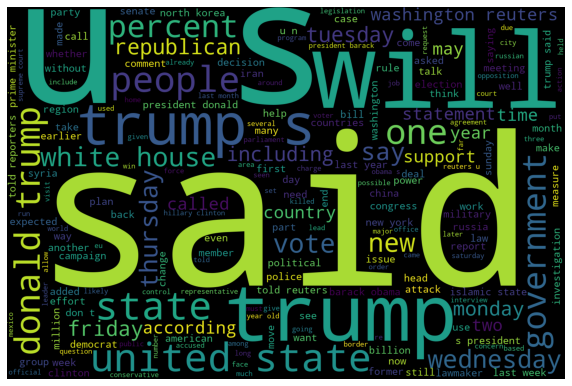

In [90]:
realText = " ".join(realDf['text'].tolist())
plt.figure(figsize=(10,20))
wordcloud = WordCloud(width=1500,height=1000).generate(realText)
plt.imshow(wordcloud)
plt.axis('off')
plt.show();

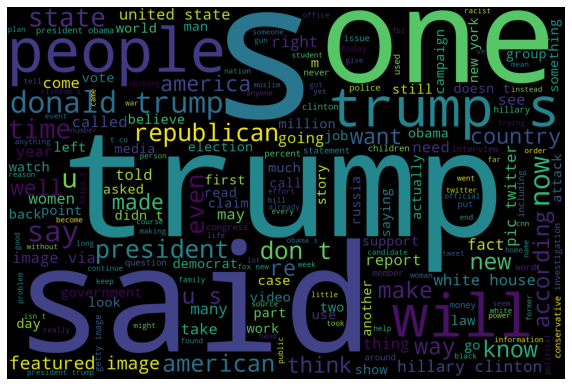

In [91]:
fakeText = " ".join(fakeDf['text'].tolist())
plt.figure(figsize=(10,20))
wordcloud = WordCloud(width=1500,height=1000).generate(fakeText)
plt.imshow(wordcloud)
plt.axis('off')
plt.show();

# Model creation

In [92]:
import gensim
y = df['class'].values
X = [d.split() for d in df['title_text'].tolist()]

In [93]:
DIM = 100
w2v_model = gensim.models.Word2Vec(sentences=X,vector_size=DIM,window=10,min_count=1)

In [94]:
len(w2v_model.wv.index_to_key)

72250

In [95]:
w2v_model.wv.most_similar('people')

[('americans', 0.7016746997833252),
 ('blacks', 0.6058754920959473),
 ('folks', 0.5856874585151672),
 ('children', 0.5631588697433472),
 ('families', 0.5576624274253845),
 ('men', 0.5556447505950928),
 ('christians', 0.540357232093811),
 ('ones', 0.5380706191062927),
 ('victims', 0.5285583734512329),
 ('adults', 0.5271720886230469)]

In [96]:
w2v_model.wv.most_similar('hate')

[('hateful', 0.8188561797142029),
 ('bigotry', 0.8120707273483276),
 ('hatred', 0.7987251877784729),
 ('racism', 0.7769798636436462),
 ('racist', 0.7668763399124146),
 ('radical', 0.6871764063835144),
 ('fear', 0.6812404990196228),
 ('antifa', 0.6785388588905334),
 ('everywhere', 0.6785328388214111),
 ('islam', 0.6783249974250793)]

In [97]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)
tokenizer.word_index

{'the': 1,
 'to': 2,
 'of': 3,
 'a': 4,
 'and': 5,
 'in': 6,
 's': 7,
 'that': 8,
 'on': 9,
 'for': 10,
 'is': 11,
 'said': 12,
 'trump': 13,
 'he': 14,
 'it': 15,
 'with': 16,
 'was': 17,
 'as': 18,
 'by': 19,
 'his': 20,
 'has': 21,
 'be': 22,
 'not': 23,
 'have': 24,
 'from': 25,
 'this': 26,
 'at': 27,
 'are': 28,
 'who': 29,
 'an': 30,
 'they': 31,
 'u': 32,
 'but': 33,
 'president': 34,
 'would': 35,
 'i': 36,
 'we': 37,
 'about': 38,
 'will': 39,
 't': 40,
 'their': 41,
 'had': 42,
 'you': 43,
 'been': 44,
 '”': 45,
 'or': 46,
 'more': 47,
 'people': 48,
 'after': 49,
 'were': 50,
 'which': 51,
 'one': 52,
 'she': 53,
 'if': 54,
 'her': 55,
 'out': 56,
 'all': 57,
 'state': 58,
 'what': 59,
 'new': 60,
 'up': 61,
 'its': 62,
 'when': 63,
 'also': 64,
 'reuters': 65,
 'house': 66,
 'over': 67,
 'no': 68,
 'there': 69,
 'clinton': 70,
 'government': 71,
 'donald': 72,
 'so': 73,
 'states': 74,
 'obama': 75,
 'republican': 76,
 'our': 77,
 'can': 78,
 'him': 79,
 'some': 80,
 'than

In [98]:
len(X)

9999

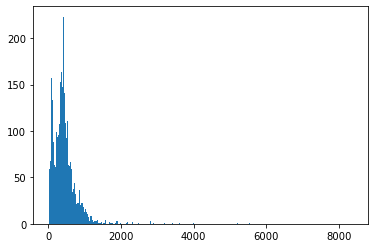

In [103]:
plt.hist([len(x) for x in X],bins=1000)
plt.show();

In [104]:
nos = np.array([len(x) for x in X])
print( len(nos[nos>1000]) )

390


In [ ]:
maxlen = 1000
X = pad_sequences(X,maxlen=maxlen)

In [ ]:
vocab_size = len(tokenizer.word_index) + 1 ## add 1 for unknown words

In [ ]:
vocab = tokenizer.word_index

def get_weight_matrix(model):
    weight_matrix = np.zeros((vocab_size,DIM))
    
    for word,i in vocab.items():
        weight_matrix[i] = model.wv[word]
        
    return weight_matrix
embedding_vectors = get_weight_matrix(w2v_model)

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size,output_dim=DIM,weights = [embedding_vectors],input_length = maxlen , trainable=False))
model.add(LSTM(units=128))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])

In [ ]:
model.summary()

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(X,y,random_state=10)

In [ ]:
model.fit(x_train,y_train,validation_split=0.3,epochs=1)

In [ ]:
y_pred = (model.predict(x_test)>=0.5).astype(int)
accuracy_test = accuracy_score(y_test,y_pred)
accuracy_test